# Speaker Recognition with Naïve Bayes and Bagging Ensemble
This notebook performs speaker recognition using audio data from two speakers: **George** and **Jackson**. It includes:
- Audio preprocessing using `librosa`
- Feature extraction (MFCCs, Spectral Rolloff, ZCR)
- Implementation of a **Naïve Bayes classifier from scratch**
- Evaluation against `scikit-learn`'s `GaussianNB`
- Implementation of **Bagging Ensemble** with Naïve Bayes and Logistic Regression

# Import Libraries

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import librosa.effects
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from collections import Counter
from sklearn.naive_bayes import GaussianNB


In [2]:
george_folder = '/Users/mac/Desktop/Projects/Supervised Third Year/Task_3/george'
jackson_folder = '/Users/mac/Desktop/Projects/Supervised Third Year/Task_3/jackson'

# Audio Preprocessing

In [3]:
import librosa
import librosa.display
import noisereduce as nr

def preprocess_audio(file_path):
    try:
        signal, sr = librosa.load(file_path)

        signal, _ = librosa.effects.trim(signal)

        ssignal = nr.reduce_noise(y=signal, sr=sr)

        signal = librosa.util.normalize(signal)

        return signal, sr
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None


# Feature Extraction

In [4]:
import numpy as np
import librosa

def extract_features(file_path):
    signal, sr = preprocess_audio(file_path)
    if signal is None:
        return None

    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    mfccs = np.mean(mfccs.T, axis=0)

    spectral_rolloff = librosa.feature.spectral_rolloff(y=signal, sr=sr)
    spectral_rolloff = np.mean(spectral_rolloff)

    zcr = librosa.feature.zero_crossing_rate(y=signal)
    zcr = np.mean(zcr)

    
    spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr)
    spectral_centroid = np.mean(spectral_centroid)

    rms = librosa.feature.rms(y=signal)
    rms = np.mean(rms)

    # Combine features
    features = np.hstack([mfccs,spectral_rolloff,zcr,spectral_centroid,rms])
    
    return features


# Load and Process Data

In [5]:
data = []
labels = []


for filename in os.listdir(george_folder):
    file_path = os.path.join(george_folder, filename)
    if os.path.isfile(file_path):
        features = extract_features(file_path)
        if features is not None:
            data.append(features)
            labels.append('george')


for filename in os.listdir(jackson_folder):
    file_path = os.path.join(jackson_folder, filename)
    if os.path.isfile(file_path):
        features = extract_features(file_path)
        if features is not None:
            data.append(features)
            labels.append('jackson')


df = pd.DataFrame(data)
df['label'] = labels


feature_columns = ([f"mfcc_{i+1}" for i in range(13)] +["spectral_rolloff", "zero_crossing_rate", "spectral_centroid", "rms"])

df.columns = feature_columns + ['label']


df = df.sample(frac=1).reset_index(drop=True)

X = df.drop(columns='label')
y = df['label']

df.head()


,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,spectral_rolloff,zero_crossing_rate,spectral_centroid,rms,label
0,-242.889145,188.605865,-109.253059,12.961057,20.458723,-46.005711,10.086054,-24.345562,-52.345509,12.353683,-12.717285,-37.350674,6.853096,2833.573775,0.076083,1466.837467,0.142143,george
1,-270.960693,143.322037,-85.077980,38.150600,42.610806,-50.591175,-12.160001,-20.956404,-48.600132,-1.226151,-20.189232,-45.149555,-1.758671,2987.242543,0.084539,1525.174283,0.131172,george
2,-256.765076,163.433655,-86.487595,37.634106,41.044476,-57.128239,-12.519463,-14.386293,-43.845688,-1.035693,-21.263649,-43.961147,-1.076823,2738.818359,0.057757,1314.578294,0.156552,george
3,-274.807770,185.810806,-104.322067,9.536158,32.465233,-53.013569,-14.534762,-16.457973,-40.016747,5.131052,-11.296746,-35.323601,-1.249900,2336.890869,0.058960,1228.283166,0.122897,george
4,-342.957825,113.762947,-15.594615,19.307251,12.978725,-26.479261,-10.550202,-15.586935,-18.529612,4.663130,-6.584318,-10.946895,5.871927,2531.381836,0.126772,1419.148699,0.063749,jackson


In [6]:
print("df shape:", df.shape)
print("number of samples:", len(df))
print("df columns:", df.columns)
print("df labels:", df['label'].value_counts())

df shape: (1000, 18)
number of samples: 1000
df columns: Index(['mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7',
       'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13',
       'spectral_rolloff', 'zero_crossing_rate', 'spectral_centroid', 'rms',
       'label'],
      dtype='object')
df labels: label
george     500
jackson    500
Name: count, dtype: int64


# Naïve Bayes Classifier from Scratch

In [7]:
class NaïveBayes:
    def __init__(self):
        self.classes = None
        self.priors = {}
        self.mean_dict = {}
        self.std_dict = {}

    def mean(self,X):
        return np.sum(X,axis=0) / X.shape[0]
    
    def std(self,X,mean):
        return np.sum((X-mean)**2, axis=0) / X.shape[0]
    
    def fit(self, X, Y):
        X = np.array(X, dtype=np.float64)
        Y = np.array(Y)

        self.classes = np.unique(Y)
        for Class in self.classes:
            X_class = X[Y == Class]
            self.priors[Class] = X_class.shape[0] / X.shape[0]
            self.mean_dict[Class] = self.mean(X_class)
            self.std_dict[Class] = self.std(X_class, self.mean_dict[Class]) + 1e-9

    def gaussian_probability(self, X, mean, var):
        exponent = np.exp(-((X-mean)**2 )/ (2*var))
        return (1/np.sqrt(2*np.pi*var))*exponent
    
    def predict(self,X):
        X = np.array(X, dtype=np.float64)
        return np.array([self.predict_single(x) for x in X])   
    
    def predict_single(self, X):
        posteriors=[]
        for Class in self.classes:
            prior = np.log(self.priors[Class])
            class_conditional = np.sum(np.log(self.gaussian_probability(X, self.mean_dict[Class], self.std_dict[Class])))
            posterior = prior + class_conditional
            posteriors.append(posterior)
        return self.classes[np.argmax(posteriors)]
    
    def evaluate(self , y_true , y_pred):
        accuracy = np.mean(y_true == y_pred)

        classes = np.unique(y_true)
        precision, recall, f1 = [], [], []

        for cls in classes:
            TP = np.sum((y_pred == cls) & (y_true == cls))
            FP = np.sum((y_pred == cls) & (y_true != cls))
            FN = np.sum((y_pred != cls) & (y_true == cls))

            p = TP / (TP + FP + 1e-9)
            r = TP / (TP + FN + 1e-9)
            f = 2 * p * r / (p + r + 1e-9)

            precision.append(p)
            recall.append(r)
            f1.append(f)

        return {
            'accuracy': accuracy,
            'precision': np.mean(precision),
            'recall': np.mean(recall),
            'f1_score': np.mean(f1)
        }
        

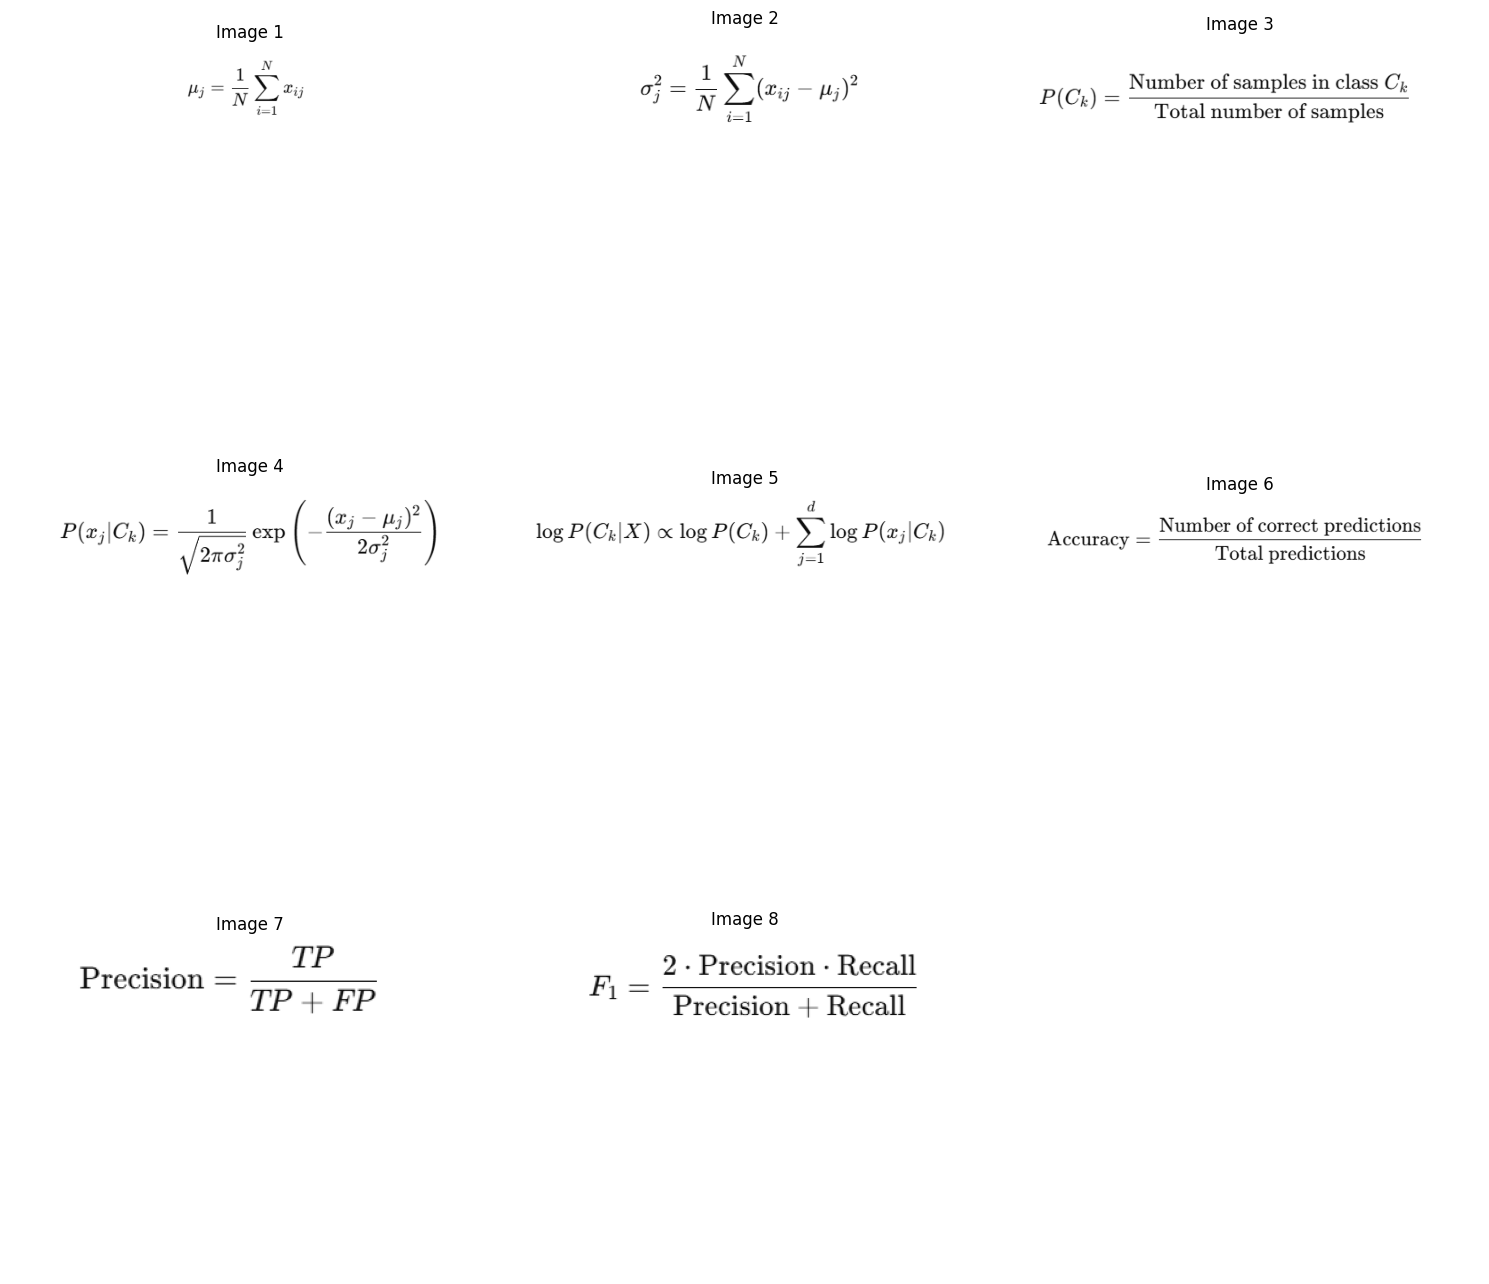

In [9]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Folder containing your screenshots
folder_path = "/Users/mac/Desktop/Projects/Supervised Third Year/Task_3/equations"  # change to your folder name

# Load image files
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

# Set target size for all images (width, height)
target_size = (400, 300)

# Adjust layout: rows and columns
num_images = len(image_files)
cols = 3  # change based on how many images you want per row
rows = (num_images + cols - 1) // cols

# Create the plot
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Flatten axes for easy iteration
axes = axes.flatten()

for i, img_file in enumerate(image_files):
    img_path = os.path.join(folder_path, img_file)
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Image {i+1}")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


# Split Data

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 800
Testing set size: 200


# Evaluate Naïve Bayes Classifier

In [11]:
model = NaïveBayes()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
results = model.evaluate(y_test, y_pred)
print("Evaluation Results:")
print(f"Accuracy : {results['accuracy']:.3f}")
print(f"Precision: {results['precision']:.3f}")
print(f"Recall   : {results['recall']:.3f}")
print(f"F1 Score : {results['f1_score']:.3f}")

Evaluation Results:
Accuracy : 0.975
Precision: 0.975
Recall   : 0.975
F1 Score : 0.975


In [12]:
# Custom Naïve Bayes
custom_model = NaïveBayes()
custom_model.fit(X_train, y_train)
y_pred_custom = custom_model.predict(X_test)
custom_results = custom_model.evaluate(y_test, y_pred_custom)

# Scikit-learn GaussianNB
sklearn_model = GaussianNB()
sklearn_model.fit(X_train, y_train)
y_pred_sklearn = sklearn_model.predict(X_test)

sklearn_results = {
    'accuracy': accuracy_score(y_test, y_pred_sklearn),
    'precision': precision_score(y_test, y_pred_sklearn, average='macro'),
    'recall': recall_score(y_test, y_pred_sklearn, average='macro'),
    'f1_score': f1_score(y_test, y_pred_sklearn, average='macro')
}

def print_results(name, results):
    print(f"\n{name} Results:")
    for metric, value in results.items():
        print(f"{metric.capitalize()}: {value:.3f}")

print_results("Custom Naïve Bayes", custom_results)
print_results("Scikit-learn GaussianNB", sklearn_results)


Custom Naïve Bayes Results:
Accuracy: 0.975
Precision: 0.975
Recall: 0.975
F1_score: 0.975

Scikit-learn GaussianNB Results:
Accuracy: 0.975
Precision: 0.975
Recall: 0.975
F1_score: 0.975


## Bagging Ensemble
Use both Naïve Bayes and Logistic Regression with bagging.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from collections import Counter

def baggingEnsamble(baseModel , x_train , y_train, estimators = 10):
    models=[]
    for i in range(estimators):
        x_sample , y_sample = resample(x_train,y_train)
        model = baseModel()
        model.fit(x_sample , y_sample)
        models.append(model)
    return models

def predictEnsamble(models , X):
    predictions = []
    for model in models:
        y_pred = model.predict(X)
        predictions.append(y_pred)
    predictions = np.array(predictions).T
    finalPredictions = [Counter(row).most_common(1)[0][0] for row in predictions]
    return finalPredictions

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print("Accuracy:", round(accuracy, 4))
    print("Precision:", round(precision, 4))
    print("Recall:", round(recall, 4))
    print("F1 Score:", round(f1, 4))

In [14]:
NB_models = baggingEnsamble(NaïveBayes , X_train,y_train)
y_pred_NB = predictEnsamble(NB_models , X_test)
LR_models = baggingEnsamble(lambda: LogisticRegression(max_iter=1000) , X_train,y_train)
y_pred_LR = predictEnsamble(LR_models , X_test)

print('Naïve Bayes:')
evaluate_model(y_test, y_pred_NB)
print('---------------------\nLogistic Regression:')
evaluate_model(y_test, y_pred_LR)

Naïve Bayes:
Accuracy: 0.975
Precision: 0.975
Recall: 0.975
F1 Score: 0.975
---------------------
Logistic Regression:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
